The contains a short implementation of learning a dynamics model to mimic a spiral ODE.
Based on:
* https://github.com/rtqichen/torchdiffeq/tree/master/examples

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow.contrib.eager as tfe

keras = tf.keras
tf.enable_eager_execution()

In [3]:
from neural_ode import NeuralODE

# Generate spiral dataset

In [4]:
data_size = 1000
batch_time = 20 # this seems to works the best ...
niters = 3000
batch_size = 16

t_grid = np.linspace(0, 25, data_size)
true_y0 = tf.to_float([[2., 0.]])
true_A = tf.to_float([[-0.1, 2.0], [-2.0, -0.1]])

## Create spiral dataset

In [5]:
class Lambda(tf.keras.Model):
    def call(self, inputs, **kwargs):
        t, r = inputs
        return tf.matmul(r**3, true_A)

Integrate spiral dynamics to obtain trajectory over time

In [6]:
neural_ode = NeuralODE(Lambda(), t=t_grid)
yN, states_history = neural_ode.forward(true_y0, return_states="numpy")

true_y = np.concatenate(states_history)
true_y.shape

(1000, 2)

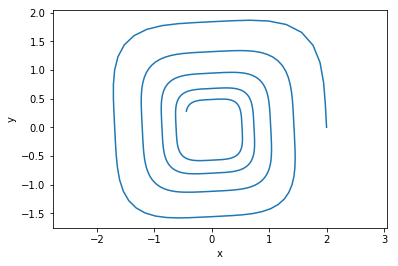

In [7]:
def plot_spiral(trajectories):
    for path in trajectories:
        plt.plot(*path.T)
    plt.axis("equal")
    plt.xlabel("x")
    plt.ylabel("y")

plot_spiral([true_y])

# Matching true end position with predicted one

## Create batch generator

Sample frament of trajectory, here we want to start from some random position `y0`, and then
force model to match final posiion `yN`

In [8]:
def get_batch():
    """Returns initial point and last point over sampled frament of trajectory"""
    starts = np.random.choice(np.arange(data_size - batch_time - 1, dtype=np.int64), batch_size, replace=False)
    batch_y0 = true_y[starts] # (batch_size, 2) -> initial point
    batch_yN = true_y[starts + batch_time]
    return tf.to_float(batch_y0), tf.to_float(batch_yN)

# Create NeuralODE

## Some neural network

In [10]:
# simple network which is used to learn trajectory
class ODEModel(tf.keras.Model):
    def __init__(self):
        super(ODEModel, self).__init__()
        self.linear1 = keras.layers.Dense(50, activation="tanh")
        self.linear2 = keras.layers.Dense(2)        

    def call(self, inputs, **kwargs):
        t, y = inputs
        h = y**3
        h = self.linear1(h)
        h = self.linear2(h)
        return h

## NeuralODE integrator with RK4 solver

In [11]:
model = ODEModel()
neural_ode = NeuralODE(model, t = t_grid[:batch_time])
optimizer = tf.train.RMSPropOptimizer(learning_rate=1e-4)

In [12]:
def compute_gradients_and_update(batch_y0, batch_yN):
    """Takes start positions (x0, y0) and final positions (xN, yN)"""
    pred_y = neural_ode.forward(batch_y0)
    with tf.GradientTape() as g:
        g.watch(pred_y)
        loss = tf.reduce_mean(tf.abs(pred_y - batch_yN))
        
    dLoss = g.gradient(loss, pred_y)
    h_start, dfdh0, dWeights = neural_ode.backward(pred_y, dLoss)
    optimizer.apply_gradients(zip(dWeights, model.weights))
    return loss

# Compile EAGER graph to static (this will be much faster)
compute_gradients_and_update = tfe.defun(compute_gradients_and_update)

  0%|          | 0/3000 [00:00<?, ?it/s]

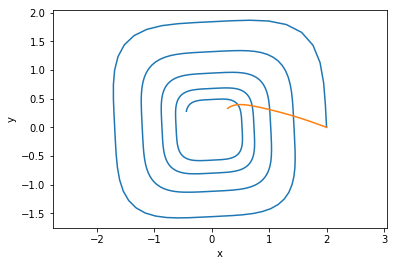

 16%|█▋        | 490/3000 [00:12<01:04, 38.88it/s]

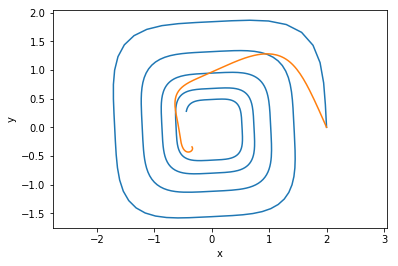

 33%|███▎      | 999/3000 [00:18<00:37, 52.73it/s]

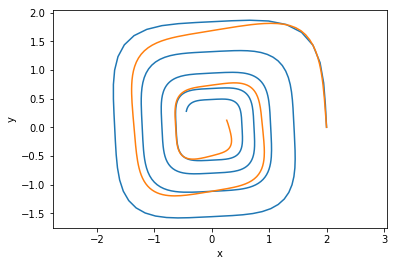

 50%|████▉     | 1497/3000 [00:25<00:25, 58.87it/s]

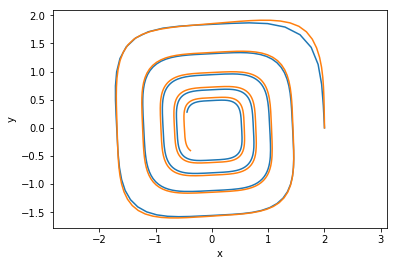

 66%|██████▋   | 1988/3000 [00:31<00:16, 62.64it/s]

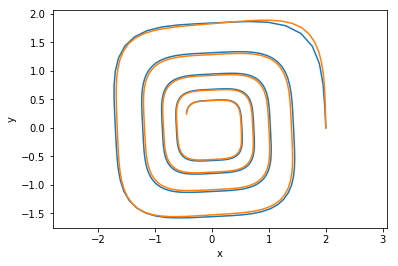

 83%|████████▎ | 2491/3000 [00:38<00:07, 64.83it/s]

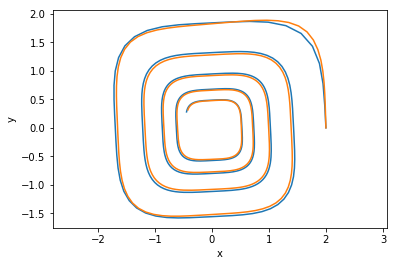

100%|██████████| 3000/3000 [00:44<00:00, 66.97it/s]


In [13]:
# Solver for testing trajectory
neural_ode_test = NeuralODE(model, t=t_grid)

loss_history = []
for step in tqdm(range(niters)):
    batch_y0, batch_yN = get_batch()
    loss = compute_gradients_and_update(batch_y0, batch_yN)
    loss_history.append(loss.numpy())
    
    if step % 500 == 0:        
        yN, states_history_model = neural_ode_test.forward(true_y0, return_states="numpy")
        # plot trajectories        
        plot_spiral([true_y, np.concatenate(states_history_model)])        
        plt.show()

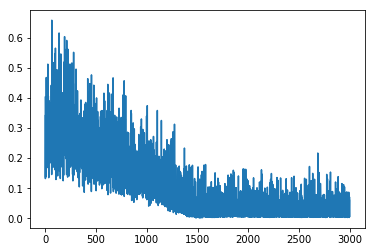

In [14]:
plt.plot(loss_history)

## Extrapolation t > 25

In [15]:
# start from position at t ~ 25
true_yN = tf.to_float([true_y[-1]])

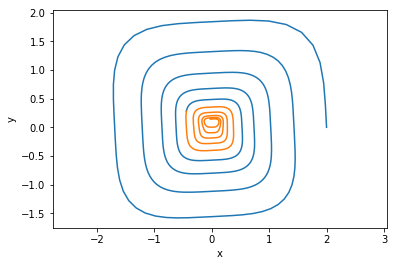

In [17]:
true_yN = tf.to_float([true_y[-1]])
neural_ode_extrapolation =  NeuralODE(model, t = np.linspace(0, 500.0, data_size))
yN, states_history_model = neural_ode_extrapolation.forward(true_yN, return_states="numpy")
plot_spiral([true_y, np.concatenate(states_history_model)])        

# Matching all points along trajectory

Instead of matching only the last position in the batch i.e. target position with predicted 
position, here we match all points along trajectory. <br> This makes problem much easier to learn.
Here we use Tensorflow autograph to compute gradients. Gradients are propagated throught RK4
solver.

In [18]:
def get_path_batch():
    starts = np.random.choice(np.arange(data_size - batch_time - 1, dtype=np.int64), batch_size, replace=False)
    batch_y0 = true_y[starts] # (batch_size, 2)
    batch_yN = [true_y[starts + i] for i in range(batch_time)] # (batch_time, batch_size, 2)
    return tf.to_float(batch_y0), tf.to_float(batch_yN)

In [19]:
[element.shape.as_list() for element in get_path_batch()]

[[16, 2], [20, 16, 2]]

In [34]:
model = ODEModel()
neural_ode = NeuralODE(model, t = t_grid[:batch_time])
neural_ode_test = NeuralODE(model, t=t_grid)

In [35]:
optimizer = tf.train.MomentumOptimizer(learning_rate=1e-3, momentum=0.95)

In [36]:
def compute_gradients_and_update_path(batch_y0, batch_yN):
    with tf.GradientTape() as g:
        
        pred_y, y_points = neural_ode.forward(batch_y0, return_states="tf")        
        pred_path = tf.stack(y_points)  # -> (batch_time, batch_size, 2)        
        loss = tf.reduce_mean(tf.abs(pred_path - batch_yN), axis=1) # -> (batch_time, 2)   
        loss = tf.reduce_mean(loss, axis=0)
    
    # backpropagate through solver with tensorflow
    gradients = g.gradient(loss, model.weights)  
    optimizer.apply_gradients(zip(gradients, model.weights))
    return loss

compute_gradients_and_update_path = tfe.defun(compute_gradients_and_update_path)

  0%|          | 0/3001 [00:00<?, ?it/s]

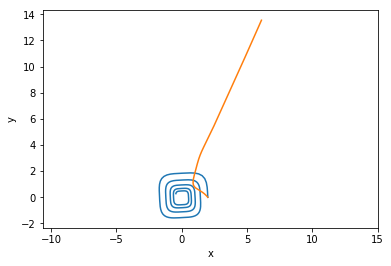

 16%|█▋        | 495/3001 [00:09<00:50, 49.91it/s]

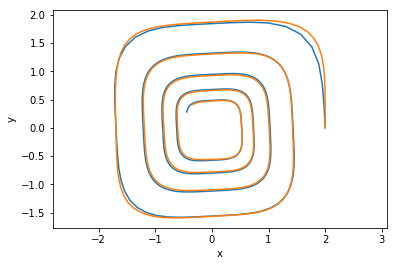

 33%|███▎      | 991/3001 [00:15<00:31, 64.25it/s]

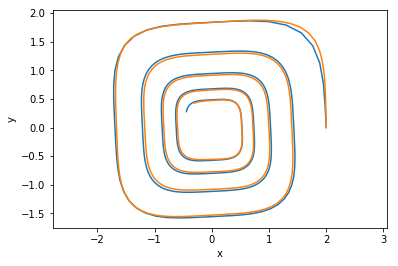

 50%|████▉     | 1497/3001 [00:20<00:20, 72.22it/s]

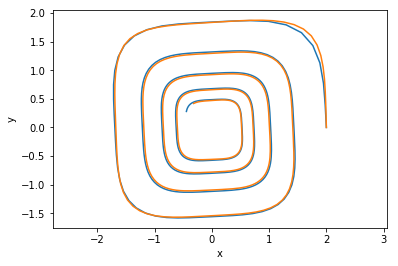

 66%|██████▌   | 1988/3001 [00:25<00:13, 76.87it/s]

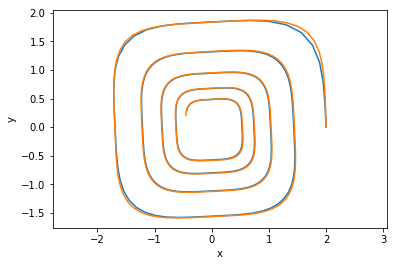

 83%|████████▎ | 2500/3001 [00:31<00:06, 79.72it/s]

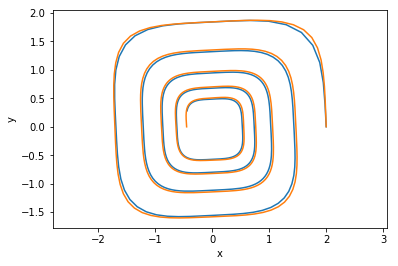

100%|█████████▉| 2996/3001 [00:36<00:00, 81.42it/s]

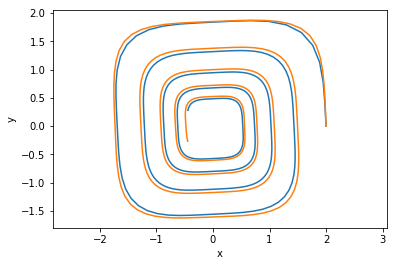

100%|██████████| 3001/3001 [00:38<00:00, 77.00it/s]


In [37]:
loss_history = []
for step in tqdm(range(niters+1)):
    batch_y0, batch_yN = get_path_batch()
    loss = compute_gradients_and_update_path(batch_y0, batch_yN)    
    loss_history.append(loss.numpy())
    
    if step % 500 == 0:        
        yN, states_history_model = neural_ode_test.forward(true_y0, return_states="numpy")        
        plot_spiral([true_y, np.concatenate(states_history_model)])        
        plt.show()

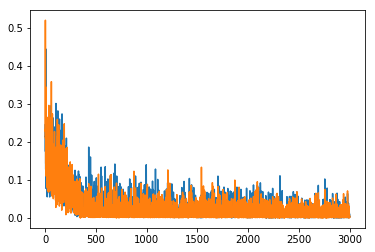

In [39]:
plt.plot(loss_history)

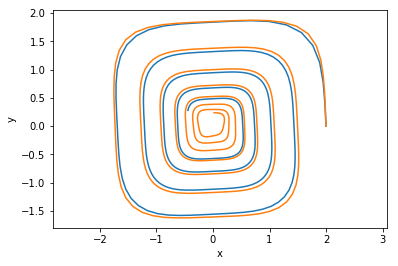

In [43]:
neural_ode_extrapolation =  NeuralODE(model, t = np.linspace(0, 150.0, 5 * data_size))       
yN, states_history_model = neural_ode_extrapolation.forward(true_y0, return_states="numpy")
plot_spiral([true_y, np.concatenate(states_history_model)])

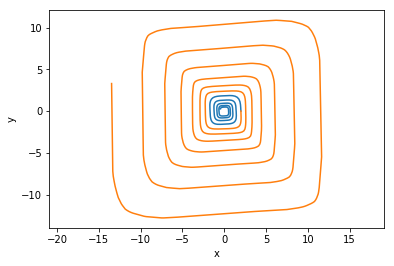

In [44]:
neural_ode_extrapolation =  NeuralODE(model, t = np.linspace(25.0, 0.0, data_size))       
yN, states_history_model = neural_ode_extrapolation.forward(true_y0, return_states="numpy")
plot_spiral([true_y, np.concatenate(states_history_model)])